# UNET RESNET TRANSFER LEARNING

In [ ]:
import sys
import os
sys.path.append("")
import random
import numpy as np # linear algebra
import utils 
import unetresnetmodel as urm


from sklearn.model_selection import train_test_split

In [ ]:
BATCH_SIZE =1
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False


ship_dir = ''
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')


In [ ]:
def sample_ships(in_df, base_rep_train=8000, base_rep_val=5000, isTraining=True ):
    '''
    oversample rare classes, use all non rare classes for training
    '''
    if isTraining:
        if in_df['ships'].values[0]==0:
            return in_df.sample(1) # even more strongly undersample no ships
        elif in_df.shape[0]>base_rep_train:
            return in_df
        else:
            return in_df.sample(base_rep_train, replace=True)
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    

In [ ]:

def mainDataProcPipeline (segmentationFileName = 'train_ship_segmentations.csv'):
    segmentationFile = os.path.join(ship_dir,segmentationFileName)
    unique_ids, shipmasks =utils.getImageIdAndShipMasks(segmentationFile, train_image_dir)
    train_ids, valid_ids = train_test_split(unique_ids, test_size = 0.3, stratify = unique_ids['ships'])
    balanced_train_df = train_ids.groupby('ships').apply(sample_ships)        
    balanced_validation_df = valid_ids.groupby('ships').apply(sample_ships)
    train_gen = utils.make_image_gen(train_image_dir, shipmasks, balanced_train_df,  batch_size= 2)
    validation_gen = utils.make_image_gen(train_image_dir, shipmasks, balanced_validation_df, batch_size= 4)
    return train_gen, validation_gen

In [ ]:
train_gen, validation_gen = mainDataProcPipeline()


# EXPLORE DATA

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util.montage import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

In [ ]:
"""
train_gen2, validation_gen2 = mainDataProcPipeline()
train_x, train_y = next(train_gen2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
"""

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                  data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)


dg_args_validation = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 0., 
                  width_shift_range = 0., 
                  height_shift_range = 0., 
                  shear_range = 0.,
                  horizontal_flip = False, 
                  vertical_flip = False,
                   data_format = 'channels_last')

image_gen_validation = ImageDataGenerator(**dg_args_validation)
label_gen_validation = ImageDataGenerator(**dg_args_validation)


validation_gen = utils.create_aug_gen(validation_gen, image_gen_validation, label_gen_validation)
cur_gen = utils.create_aug_gen(train_gen, image_gen, label_gen)

In [ ]:
#t_x, t_y = next(cur_gen)
#cur_gen2 = utils.create_aug_gen(validation_gen, image_gen, label_gen)
#t_x, t_y = next(cur_gen2)
#print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
#print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
#t_x = t_x[:9]
#t_y = t_y[:9]
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
#ax1.imshow(montage_rgb(t_x), cmap='gray')
#ax1.set_title('images')
#ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
#ax2.set_title('ships')

# GET MODEL AND  TRAIN

In [ ]:

segmodel =urm.UnetResnetModel().getModel()

In [ ]:
def trainModel (unetModel, weight_path, train_data_generator, validation_data_generator , callbacks_list):

    
    loss_history1 = [unetModel.fit_generator(train_data_generator, 
                             steps_per_epoch=200, 
                             epochs=5, 
                             validation_data= validation_data_generator,
                             callbacks=callbacks_list,
                            validation_steps = 1,
                             workers=1 # the generator is not very thread safe
                                       )]

    for l in unetModel.layers:
        l.trainable = True
        
    #train all
    loss_history = [unetModel.fit_generator(train_data_generator, 
                             steps_per_epoch=2, 
                             epochs=2, 
                             validation_data= validation_data_generator,
                             callbacks=callbacks_list,
                            validation_steps = 2,
                             workers=1 
                                       )]
    return loss_history

In [ ]:
from keras import optimizers
from unetresnetmodel import dice_p_bce, my_iou_metric, dice_coef,true_positive_rate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

optim = optimizers.Adam(1e-4, decay=1e-6)
segmodel.compile(optimizer=optim, loss=dice_p_bce, metrics=[my_iou_metric,dice_coef,true_positive_rate, 'binary_accuracy', 'binary_crossentropy'])

weight_path="{}_resnet50simple_weights.best.hdf5".format('seg_model')
checkpoint = ModelCheckpoint(weight_path, monitor='val_my_iou_metric', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=7, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-10)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15)
callbacks_list = [checkpoint, reduceLROnPlat, early]
lossHistory = trainModel (unetModel=segmodel ,weight_path= weight_path ,train_data_generator=cur_gen, validation_data_generator=validation_gen , callbacks_list=callbacks_list )



In [25]:
#load best weight
segmodel.load_weights(weight_path,by_name=True)

## View Results

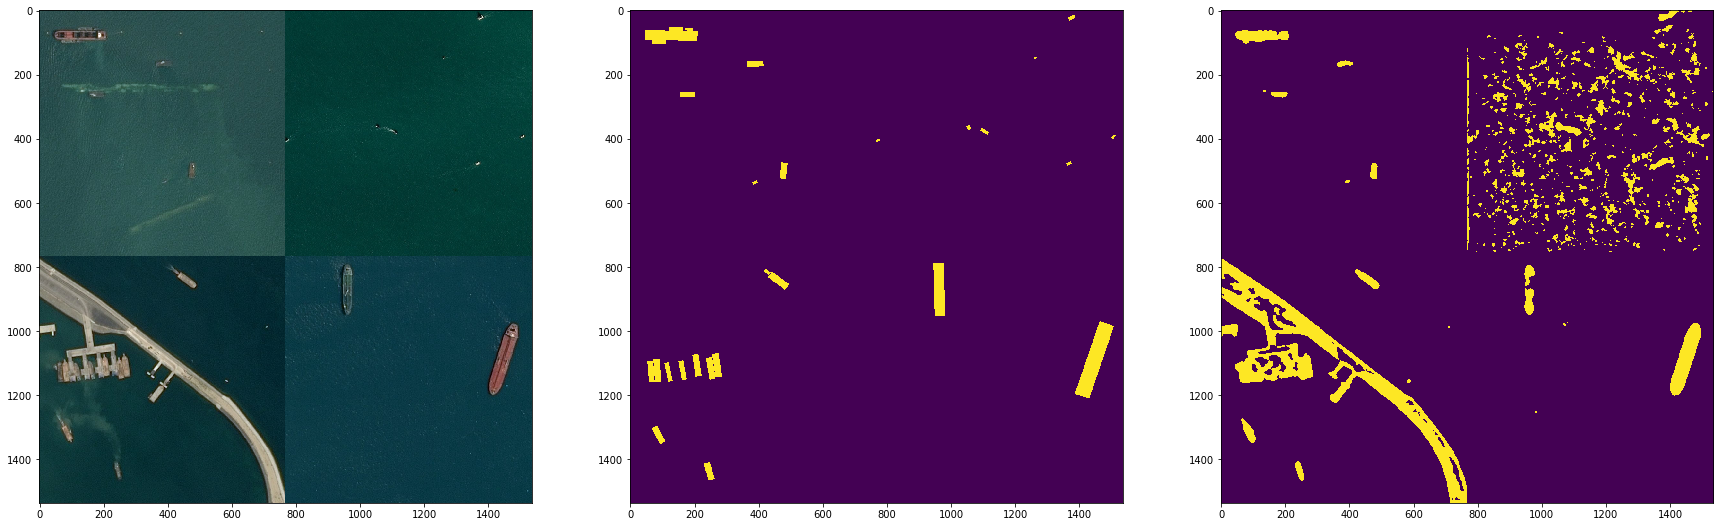

In [26]:
train_x, train_y = next(validation_gen)
train_x = train_x[0:4, :, :, :]
train_y = train_y[0:4, :, :, :]
predicted = segmodel.predict(train_x)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
predi =montage(predicted[:, :, :, 0]>0.5)
ax1.imshow(batch_rgb)#ax1.set_title('Images')
ax2.imshow(batch_seg) #ax2.set_title('Segmentations')
ax3.imshow(predi)#ax3.set_title('Outlined Ships')

In [ ]:
#Plot performance jistory from  training log 

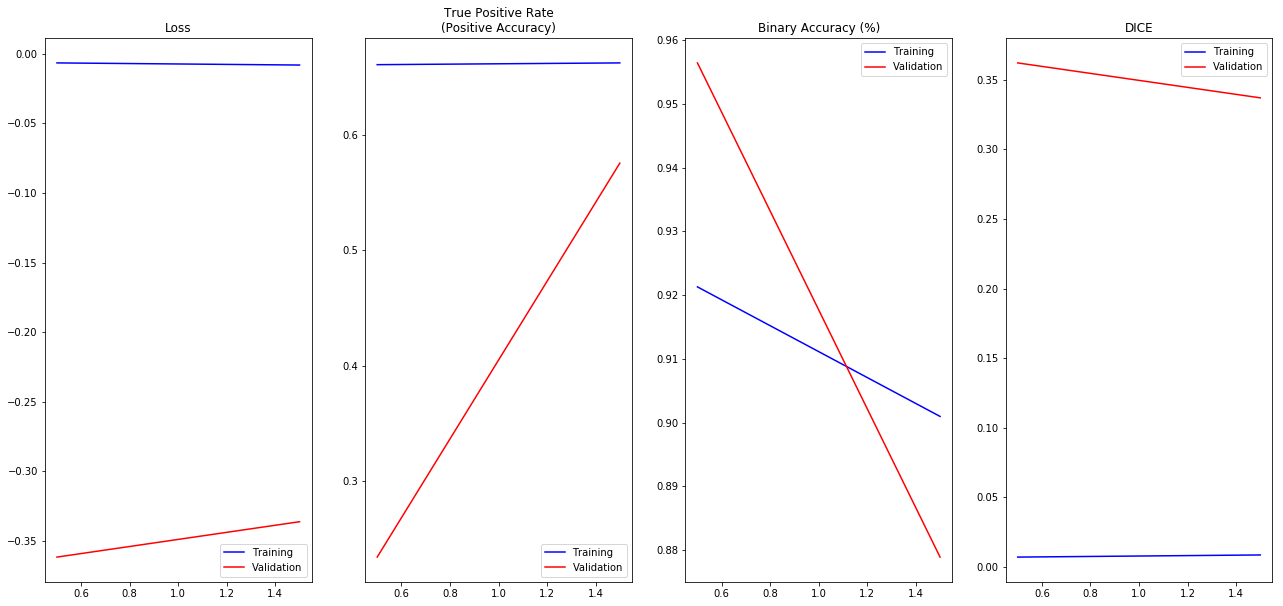

In [23]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['binary_crossentropy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_crossentropy'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(lossHistory)

# Execute Model on Test Data

In [ ]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')
fullres_model = seg_model

In [ ]:
np.random.shuffle(test_paths)
fig, m_axs = plt.subplots(5, 2, figsize = (20, 30))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    #print(rle_encode(np.round(first_seg[0, :, :, :])) )#multi_rle_encode
    ax2.imshow(np.round(first_seg[0, :, :, 0]), vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

In [ ]:
from tqdm import tqdm_notebook
from skimage.morphology import binary_opening, disk
out_pred_rows = []
count =0
for c_img_name in tqdm_notebook(test_paths):
    count = count +1
    if (count%500==0):
        print(count)
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles)>0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()


In [ ]:
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(30)